# **Generative Adversarial Networks (GANs) in PyTorch - Deep Convolutional GANs or DCGAN with MNIST**

---

In this lesson, we will learn how to use PyTorch to create a simple DCGAN using the MNIST dataset.

## **1. Setting up our data and modules**

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42)

cuda


## **2. Fetch our MNIST Dataset using torchvision and Create our transforms and Data Loader**

In [2]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 54961103.20it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112475110.33it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 81716250.12it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2079071.13it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## **3. Define our Discriminator Model**

Our Descriminator receives the 28x28 image generated by our Generator and outputs a probability score of it belonging to the original dataset or not.

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # We don't use Conv layers here but we vectorize our inputs
            nn.Linear(784, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

# We instantiate our mode and send it to the GPU
discriminator = Discriminator().to(device=device)

## **5. Define our Generator Model**

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), # We use the Tanh() activation fucntion so that our outputs lie between -1 and 1
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

# We instantiate our mode and send it to the GPU
generator = Generator().to(device=device)

## **Set our training parameters**

In [5]:
# Set our learning rate, epochs
lr = 0.0001
epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [6]:
for epoch in range(10):
    for n, (samples, labels) in enumerate(train_loader):
        # Get data for training the discriminator
        real_samples = samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Descrimianted Loss: {loss_discriminator}")
            print(f"Epoch: {epoch} Generator Loss: {loss_generator}")

Epoch: 0 Descrimianted Loss: 0.49982163310050964
Epoch: 0 Generator Loss: 0.7470247745513916
Epoch: 1 Descrimianted Loss: 0.014356503263115883
Epoch: 1 Generator Loss: 6.670928001403809
Epoch: 2 Descrimianted Loss: 0.004309533629566431
Epoch: 2 Generator Loss: 7.132286071777344
Epoch: 3 Descrimianted Loss: 0.06950131803750992
Epoch: 3 Generator Loss: 9.165077209472656
Epoch: 4 Descrimianted Loss: 0.012347932904958725
Epoch: 4 Generator Loss: 5.800023555755615
Epoch: 5 Descrimianted Loss: 0.05877348408102989
Epoch: 5 Generator Loss: 5.16384220123291
Epoch: 6 Descrimianted Loss: 0.005278092343360186
Epoch: 6 Generator Loss: 5.184131622314453
Epoch: 7 Descrimianted Loss: 0.0005113229854032397
Epoch: 7 Generator Loss: 9.114925384521484
Epoch: 8 Descrimianted Loss: 0.00010649045725585893
Epoch: 8 Generator Loss: 9.419779777526855
Epoch: 9 Descrimianted Loss: 0.03527870774269104
Epoch: 9 Generator Loss: 5.5619916915893555


## **5. Now let's Inspect our Generated Samples**

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

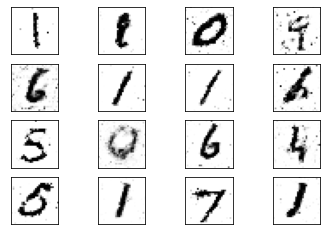

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])